In [193]:
!python -V

Python 3.9.7


#注意：model explanation的变量需要与modeldevelop的时候，变量顺序一致；也就是说excel里面以及本程序里面设置的变量需要与modeldevelop里面的变量保持一致。

In [194]:
import pickle
import random

import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion

from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [195]:
# %matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 18

## Making machine learning pipleline

LIME explainers take in the original raw data for model explanation (for human understandable explainations), so the target model has to include the preprocessing steps. So the following pipleline is largely a repeat of what's done in the preprocessing and omitting the model fitting steps.

In [196]:
train = pd.read_excel(r'E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Data/start0.9-number - only needed.xlsx')
test = pd.read_excel(r'E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Data/starv0.1-number - only needed.xlsx')

print(train.shape)
print(test.shape)
train.head()

(106492, 15)
(11735, 15)


,Sex,Race,Primary.site,Marital.status,Rural.urban,Tstage,Nstage,Brain.m,Liver.m,Lung.m,Cancer.directed.surgery,Radiation,Chemotherapy,Age,died_hosp
0,1,2,3,2,1,5,3,1,1,1,1,2,2,72,0
1,2,1,3,4,1,5,3,3,3,1,1,2,2,61,0
2,2,4,3,1,1,4,4,1,1,1,1,1,1,79,1
3,2,4,1,2,1,3,1,1,1,1,1,1,1,87,0
4,2,4,1,4,1,6,5,1,1,1,1,1,1,69,0


In [197]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106492 entries, 0 to 106491
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   Sex                      106492 non-null  int64
 1   Race                     106492 non-null  int64
 2   Primary.site             106492 non-null  int64
 3   Marital.status           106492 non-null  int64
 4   Rural.urban              106492 non-null  int64
 5   Tstage                   106492 non-null  int64
 6   Nstage                   106492 non-null  int64
 7   Brain.m                  106492 non-null  int64
 8   Liver.m                  106492 non-null  int64
 9   Lung.m                   106492 non-null  int64
 10  Cancer.directed.surgery  106492 non-null  int64
 11  Radiation                106492 non-null  int64
 12  Chemotherapy             106492 non-null  int64
 13  Age                      106492 non-null  int64
 14  died_hosp                106492 non-

In [198]:
vars_to_remove = ['age_group', 'treat_lmt', 'age_group', 'admepisode','apache3riskofdeath', 'anzrodriskofdeath', 'apache3score']
def remove_variables(df, vars_to_remove):
    df.drop(vars_to_remove, axis=1, inplace=True, errors='ignore')

In [199]:
remove_variables(test, vars_to_remove)
remove_variables(train, vars_to_remove)
print(train.shape)
print(test.shape)

(106492, 15)
(11735, 15)


LIME needs raw training data of type float. This means `sex` column in the data needs to be transformed.

### Data preprocessing

In [200]:
categorical_vars = ["Sex",
"Race",
"Primary.site",
"Marital.status",
"Rural.urban",
"Tstage",
"Nstage",
"Brain.m",
"Liver.m",
"Lung.m",
"Cancer.directed.surgery",
"Radiation",
"Chemotherapy"]
categorical_var_idxs = [idx for idx, _ in enumerate(list(train.columns)) if _ in categorical_vars]###！严格按照顺序进行排序变量

numerical_vars = ['Age']
numerical_var_idxs = [idx for idx, _ in enumerate(list(train.columns)) if _ in numerical_vars]

print(categorical_var_idxs) 
print(numerical_var_idxs)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[13]


In [201]:
# to make a custom transformer to fit into a pipeline
class Vars_selector(BaseEstimator, TransformerMixin):
    '''Return a subset of variables in a numpy array based on indecies'''
    def __init__(self, var_idxs):
        '''var_idxs is a list of categorical variables indecies'''
        self.var_idxs = var_idxs
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        '''returns a dataframe with selected variables'''
        return np.array(X)[:, self.var_idxs]

In [202]:
class Cat_vars_encoder(BaseEstimator, TransformerMixin):
    '''Return the transformed categorical variables based on indecies'''
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # arf column index
        # arf_idx = categorical_vars.index('arf')
        # X[:, arf_idx] = np.array(pd.Series(X[:, arf_idx]).map({1:1, 2:0})) # 1 -> Yes(1), 2 -> No(0)
        return X

**Transform data in a pipeline** 

In [203]:
# categorical variables preprocessing
cat_vars_pipeline = Pipeline([
    ('selector', Vars_selector(categorical_var_idxs)),
    ('encoder', Cat_vars_encoder())
])

In [204]:
# numerical variables preprocessing
num_vars_pipeline = Pipeline([
    ('selector', Vars_selector(numerical_var_idxs)),
    ('standardizer', StandardScaler())
])

To transform the two types of variables in one step

In [205]:
preproc_pipeline = FeatureUnion(transformer_list=[
    ('cat_pipeline', cat_vars_pipeline),
    ('num_pipeline', num_vars_pipeline)
])

_restore the models and fit them into pipeline_

In [206]:
with open('E:/R code-LMX/R code for SEER-Bone metastasis-LYS/Models/gbm_clf_final_round.pkl', 'rb') as f:
    ensemble_clf = pickle.load(f)    

In [207]:
## for ensemble_clf:
class Ensemble_clf(BaseEstimator, ClassifierMixin):
    def fit(self, X, y=None):
        return ensemble_clf
    def predict_proba(self, X):
        return ensemble_clf.predict_proba(X)    

In [208]:
## for ensemble_clf
ensemble_pipeline = Pipeline([
    ('preprocessing', FeatureUnion(transformer_list=[
                            ('cat_pipeline', cat_vars_pipeline),
                            ('num_pipeline', num_vars_pipeline),
                        ])),
    ('ensemble_clf', Ensemble_clf())
])

In [209]:
ensemble_pipeline.fit(train)

Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('cat_pipeline',
                                                 Pipeline(steps=[('selector',
                                                                  Vars_selector(var_idxs=[0,
                                                                                          1,
                                                                                          2,
                                                                                          3,
                                                                                          4,
                                                                                          5,
                                                                                          6,
                                                                                          7,
                                                                               

#### Preparing a LIME explainer

Because LIME takes only float numpy array of the original dataset, to provide a human understandable explanation, it needs to know the mapping from the encoded value to original value for the categorical variables.

This is accomplished through the categorical_names argument. This is a dictionary of a list of values mapped to the index of the (categorical) variable column.

In [210]:
# make the categorical original values mapping
## the order of the names should correspond to their (int) encoded values
### arf, gcsverb, gcsmotor, and gcseye have the original data in numbers but not start from 0,
### hence the empty string in front of the values list for them. 
### This is required for LIME, because LIME uses these to index the categorical_names list
###注意原始数据不是从0开始的，前面多一个，！！！
categorical_vals = '''Sex=, Female, Male
Race=,Black, Other, Unknown, White
Primary.site=,Slow, Moderate, Rapid
Marital.status=, Divorced, Married, Separated, Single, Unknown, Unmarried_or_Domestic_Partner, Widowed
Rural.urban=, Metropolitan counties, Nonmetropolitan counties, Unknown
Tstage=, T0, T1, T2, T3, T4, TX
Nstage=, N0, N1, N2, N3, NX
Brain.m=, No, Unknown, Yes
Liver.m=, No, Unknown, Yes
Lung.m=, No, Unknown, Yes
Cancer.directed.surgery=, No, Unknown, Yes
Radiation=, None, Yes
Chemotherapy=, None, Yes'''.split('\n')

categorical_names = {}
for val in categorical_vals:
    categorical_names[categorical_var_idxs[categorical_vars.index(val.split('=')[0])]] = val.split('=')[1].split(',')

In [211]:
categorical_var_idxs

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [212]:
categorical_names

{0: ['', ' Female', ' Male'],
 1: ['', 'Black', ' Other', ' Unknown', ' White'],
 2: ['', 'Slow', ' Moderate', ' Rapid'],
 3: ['',
  ' Divorced',
  ' Married',
  ' Separated',
  ' Single',
  ' Unknown',
  ' Unmarried_or_Domestic_Partner',
  ' Widowed'],
 4: ['', ' Metropolitan counties', ' Nonmetropolitan counties', ' Unknown'],
 5: ['', ' T0', ' T1', ' T2', ' T3', ' T4', ' TX'],
 6: ['', ' N0', ' N1', ' N2', ' N3', ' NX'],
 7: ['', ' No', ' Unknown', ' Yes'],
 8: ['', ' No', ' Unknown', ' Yes'],
 9: ['', ' No', ' Unknown', ' Yes'],
 10: ['', ' No', ' Unknown', ' Yes'],
 11: ['', ' None', ' Yes'],
 12: ['', ' None', ' Yes']}

LIME perturbs the training sample to build a locally linear model to approximate the target model at the test point. 

In [213]:
explainer = LimeTabularExplainer(
    train.iloc[:, :-1].values, # remove the target variable from the training set that's fed into LIME
    class_names=['Survived','Died'],
    feature_names=list(train.columns),
    categorical_features=categorical_var_idxs,
    categorical_names=categorical_names,
    verbose=True
)

In [214]:
categorical_names

{0: ['', ' Female', ' Male'],
 1: ['', 'Black', ' Other', ' Unknown', ' White'],
 2: ['', 'Slow', ' Moderate', ' Rapid'],
 3: ['',
  ' Divorced',
  ' Married',
  ' Separated',
  ' Single',
  ' Unknown',
  ' Unmarried_or_Domestic_Partner',
  ' Widowed'],
 4: ['', ' Metropolitan counties', ' Nonmetropolitan counties', ' Unknown'],
 5: ['', ' T0', ' T1', ' T2', ' T3', ' T4', ' TX'],
 6: ['', ' N0', ' N1', ' N2', ' N3', ' NX'],
 7: ['', ' No', ' Unknown', ' Yes'],
 8: ['', ' No', ' Unknown', ' Yes'],
 9: ['', ' No', ' Unknown', ' Yes'],
 10: ['', ' No', ' Unknown', ' Yes'],
 11: ['', ' None', ' Yes'],
 12: ['', ' None', ' Yes']}

In [215]:
categorical_var_idxs

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [216]:
list(train.columns)

['Sex',
 'Race',
 'Primary.site',
 'Marital.status',
 'Rural.urban',
 'Tstage',
 'Nstage',
 'Brain.m',
 'Liver.m',
 'Lung.m',
 'Cancer.directed.surgery',
 'Radiation',
 'Chemotherapy',
 'Age',
 'died_hosp']

In [217]:
###train.iloc[:, :-1]

In [223]:
def get_test_sample(model, survived=True, correct=True, seed=42, count=1):
    '''
    Return one random sample from test set based on the selection criteria.
    
    parameters:
      model - the model which is tested for
      survived - select survived sample
      correct - select the sample which the model prediected correctly
    '''
    test_sample = test.loc[test['died_hosp']==1,["Sex",
"Race",
"Primary.site",
"Marital.status",
"Rural.urban",
"Tstage",
"Nstage",
"Brain.m",
"Liver.m",
"Lung.m",
"Cancer.directed.surgery",
"Radiation",
"Chemotherapy","Age"                                                
                                                ]]##此处需要修改！！！严格按照顺序进行排序变量
    prediction = model.predict_proba(test_sample)
    
    if (survived and correct) or (not survived and not correct):
        ids = np.argwhere((prediction[:,0] > prediction[:,1]))
    elif (survived and not correct) or (not survived and correct):
        ids = np.argwhere((prediction[:,0] <= prediction[:,1]))
    if count == 1:
        idx = random.Random(seed).choice(ids)   
    else:
        ids = ids.reshape(len(ids)).tolist()
        idx = random.Random(seed).sample(ids, count)
    
    return test_sample.iloc[idx,:]

In [224]:

test.iloc[:, 0:15]

,Sex,Race,Primary.site,Marital.status,Rural.urban,Tstage,Nstage,Brain.m,Liver.m,Lung.m,Cancer.directed.surgery,Radiation,Chemotherapy,Age,died_hosp
0,2,1,3,2,1,6,5,1,1,1,1,1,2,68,0
1,1,4,3,7,1,6,1,1,3,2,1,1,1,83,1
2,2,4,3,2,1,4,2,1,3,1,1,1,2,73,0
3,2,4,3,1,1,3,1,1,1,1,1,2,2,84,0
4,1,4,3,4,1,3,3,3,1,3,1,2,1,76,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11730,2,4,3,7,2,4,4,1,1,3,1,1,1,74,1
11731,2,1,3,7,2,3,5,1,3,1,1,1,1,76,1
11732,1,1,3,7,2,4,4,3,1,1,1,2,1,56,1
11733,1,4,2,2,1,5,2,1,1,1,3,2,1,58,1


In [146]:
test['died_hosp'] == (0)

0         True
1        False
2         True
3         True
4         True
         ...  
11730    False
11731    False
11732    False
11733    False
11734    False
Name: died_hosp, Length: 11735, dtype: bool

In [225]:
def plot_vertical_bar(explaination, title='Local explanation for class died'):
    exp_list = explaination.as_list()
    tags, values, colors = [],[],[]
    for i in range(len(exp_list)):
        tags.append(exp_list[i][0])
        values.append(exp_list[i][1])
        if(exp_list[i][1] > 0):
            colors.append('r')
        else:
            colors.append('g')
            
    fig, ax = plt.subplots()

    y_pos = np.arange(len(tags))

    ax.barh(y_pos, values, align='center',
            color=colors, ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(tags)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_title(title)

In [226]:
def score_compare(x, y, threshold = 0.36):
    if x < threshold and y < threshold:
        return 'True Negative'
    elif x < threshold and y > threshold:
        return 'False Negative'
    elif x > threshold and y > threshold:
        return 'True Positive'
    elif x > threshold and y < threshold:
        return 'False Positive'

In [227]:
test_sample_surived_correct = get_test_sample(ensemble_pipeline, survived=False, seed=20, count=1)##seed=2, 8,11,14用于文章
test_sample_surived_correct

,Sex,Race,Primary.site,Marital.status,Rural.urban,Tstage,Nstage,Brain.m,Liver.m,Lung.m,Cancer.directed.surgery,Radiation,Chemotherapy,Age
11430,1,4,3,2,2,3,2,1,3,3,1,1,1,79


In [228]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_surived_correct)
score = round(result[0,0],2)
score=1-score##互斥，所以我加了一个1-score
score=round(score,2)
score

0.9

Let's see how LIME explainer (with default settings) explains it.

In [229]:
explaination = explainer.explain_instance(test_sample_surived_correct.values.ravel(), ensemble_pipeline.predict_proba)

Intercept -0.18040144237174227
Prediction_local [0.85387048]
Right: 0.9019888187123741


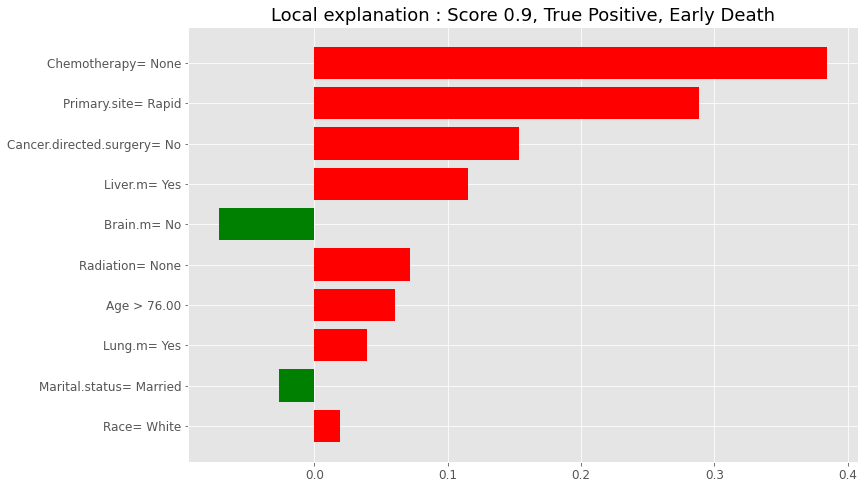

In [230]:
outcome = 1
outcome_title = 'Early Death'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, {}'.format(score, score_compare(score, outcome), outcome_title))

In [231]:
test_sample_surived_correct = get_test_sample(ensemble_pipeline, survived=False, seed=15, count=1)
test_sample_surived_correct

,Sex,Race,Primary.site,Marital.status,Rural.urban,Tstage,Nstage,Brain.m,Liver.m,Lung.m,Cancer.directed.surgery,Radiation,Chemotherapy,Age
3559,1,1,3,4,1,2,1,3,3,1,1,1,1,52


In [232]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_surived_correct)
score = round(result[0,0],2)
score=1-score##互斥，所以我加了一个1-score
score

0.89

In [233]:
explaination = explainer.explain_instance(test_sample_surived_correct.values.ravel(), ensemble_pipeline.predict_proba)

Intercept -0.14966771586948413
Prediction_local [0.78408987]
Right: 0.8915508383862869


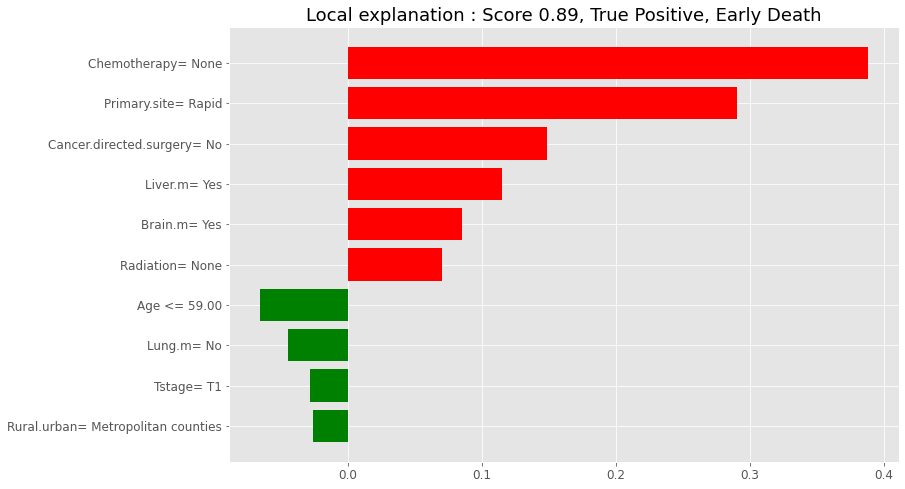

In [235]:
outcome = 1
outcome_title = 'Early Death'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, {}'.format(score, score_compare(score, outcome), outcome_title))

In [236]:
def get_test_sample(model, survived=True, correct=True, seed=42, count=1):
    '''
    Return one random sample from test set based on the selection criteria.
    
    parameters:
      model - the model which is tested for
      survived - select survived sample
      correct - select the sample which the model prediected correctly
    '''
    test_sample = test.loc[test['died_hosp']==0,["Sex",
"Race",
"Primary.site",
"Marital.status",
"Rural.urban",
"Tstage",
"Nstage",
"Brain.m",
"Liver.m",
"Lung.m",
"Cancer.directed.surgery",
"Radiation",
"Chemotherapy","Age" ]]###此处改为了“==0”则为计算阴性事件。
    prediction = model.predict_proba(test_sample)
    
    if (survived and correct) or (not survived and not correct):
        ids = np.argwhere((prediction[:,0] > prediction[:,1]))
    elif (survived and not correct) or (not survived and correct):
        ids = np.argwhere((prediction[:,0] <= prediction[:,1]))
    if count == 1:
        idx = random.Random(seed).choice(ids)   
    else:
        ids = ids.reshape(len(ids)).tolist()
        idx = random.Random(seed).sample(ids, count)
    
    return test_sample.iloc[idx,:]

In [237]:
def plot_vertical_bar(explaination, title='Local explanation for class died'):
    exp_list = explaination.as_list()
    tags, values, colors = [],[],[]
    for i in range(len(exp_list)):
        tags.append(exp_list[i][0])
        values.append(exp_list[i][1])
        if(exp_list[i][1] > 0):
            colors.append('r')
        else:
            colors.append('g')
            
    fig, ax = plt.subplots()

    y_pos = np.arange(len(tags))

    ax.barh(y_pos, values, align='center',
            color=colors, ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(tags)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_title(title)

In [247]:
test_sample_surived_correct = get_test_sample(ensemble_pipeline, survived=True, seed=2, count=1)###seed=1, 3, 5用于文章; 6  14  21true negative
test_sample_surived_correct

,Sex,Race,Primary.site,Marital.status,Rural.urban,Tstage,Nstage,Brain.m,Liver.m,Lung.m,Cancer.directed.surgery,Radiation,Chemotherapy,Age
828,2,4,1,4,1,3,1,1,1,1,1,1,1,68


In [248]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_surived_correct)
score = round(result[0,0],2)
score=1-score##互斥，所以我加了一个1-score
score=round(score,2)
score

0.06

In [249]:
explaination = explainer.explain_instance(test_sample_surived_correct.values.ravel(), ensemble_pipeline.predict_proba)

Intercept 0.30069852132641617
Prediction_local [0.25540699]
Right: 0.05894128872153578


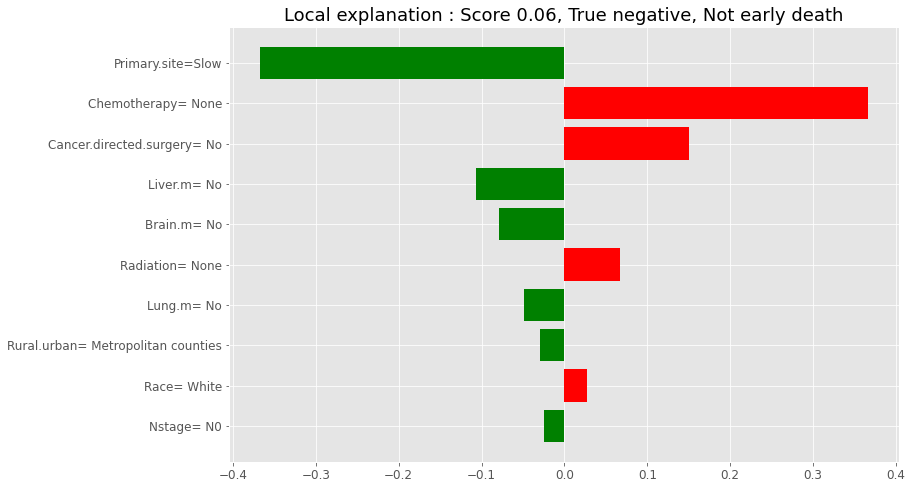

In [251]:
outcome = 1
outcome_title = 'Not early death'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, {}'.format(score, 'True negative', outcome_title))

In [242]:
test_sample_surived_correct = get_test_sample(ensemble_pipeline, survived=True, seed=16, count=1)
test_sample_surived_correct

,Sex,Race,Primary.site,Marital.status,Rural.urban,Tstage,Nstage,Brain.m,Liver.m,Lung.m,Cancer.directed.surgery,Radiation,Chemotherapy,Age
5211,1,2,1,2,1,3,2,3,1,3,1,1,1,55


In [243]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_surived_correct)
score = round(result[0,0],2)
score=1-score##互斥，所以我加了一个1-score
score=round(score,2)
score

0.19

In [244]:
explaination = explainer.explain_instance(test_sample_surived_correct.values.ravel(), ensemble_pipeline.predict_proba)

Intercept 0.1990604364751713
Prediction_local [0.32730512]
Right: 0.1866903641228389


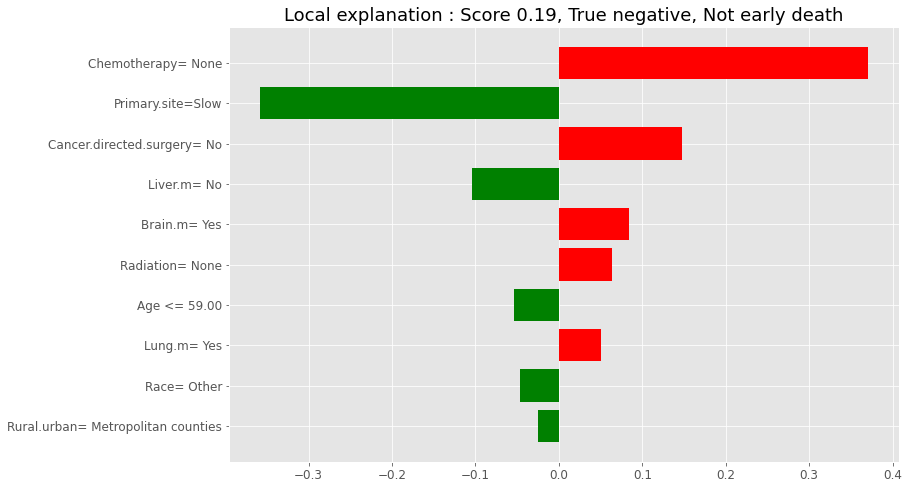

In [246]:
outcome = 1
outcome_title = 'Not early death'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, {}'.format(score, 'True negative', outcome_title))

In [63]:
test_sample_surived_correct = get_test_sample(ensemble_pipeline, seed=43) #, survived=True, correct=True, seed=42
test_sample_surived_correct

,x1,x2,x5,x6,x7,x9,x15,x16
40,0,2,1,0,0,1,1,3


In [67]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_surived_correct)
score = round(result[0,0],2)
score

0.46

Intercept 0.2576487078229592
Prediction_local [0.38524761]
Right: 0.5361814637013069


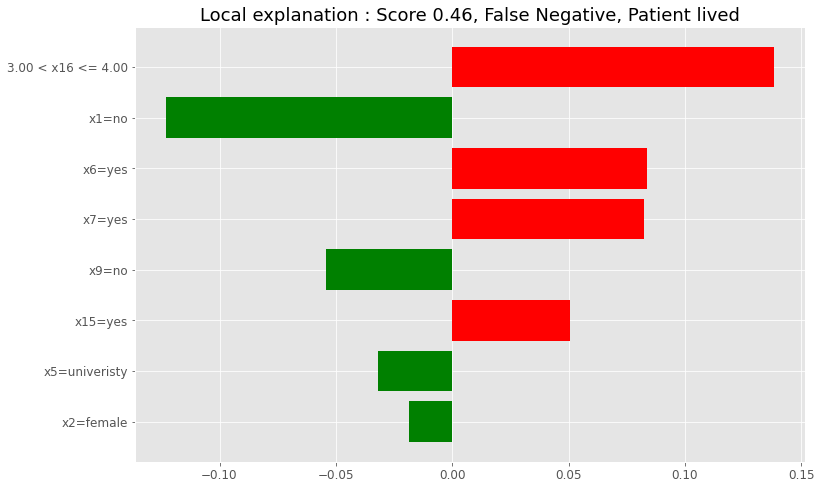

In [68]:
explaination = explainer.explain_instance(test_sample_surived_correct.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 1
outcome_title = 'lived'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

In [153]:
test_sample_surived_correct = get_test_sample(ensemble_pipeline, survived=False, correct=False, seed=10) #, correct=True, seed=42
test_sample_surived_correct

,x1,x2,x5,x6,x7,x9,x15,x16
42,0,2,1,0,0,1,0,5


In [154]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_surived_correct)
score = round(result[0,0],2)
score

0.54

In [155]:
explaination = explainer.explain_instance(test_sample_surived_correct.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 0
outcome_title = 'died'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

IndexError: list index out of range

In [156]:
test_sample_surived_correct = get_test_sample(ensemble_pipeline, survived=False, correct=True, seed=41) #, correct=True, seed=42
test_sample_surived_correct

,x1,x2,x5,x6,x7,x9,x15,x16
45,0,1,2,1,1,0,1,4


In [157]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_surived_correct)
score = round(result[0,0],2)
score

0.46

Intercept 0.23941513803221098
Prediction_local [0.40171673]
Right: 0.5361814637013069


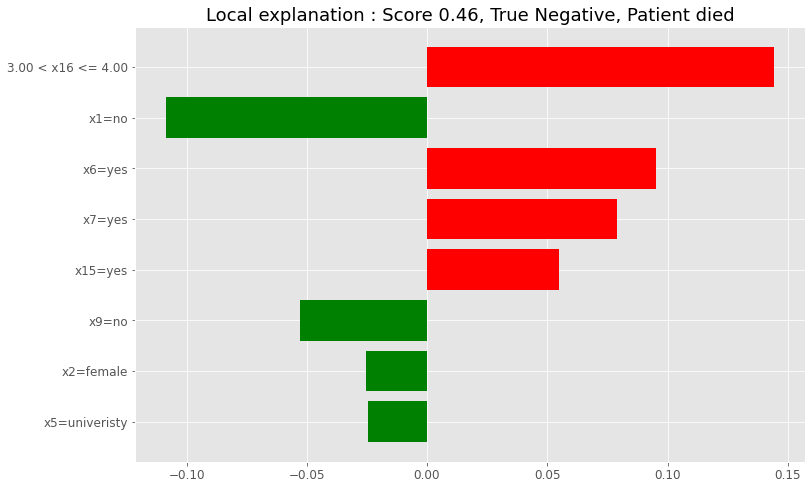

In [158]:
explaination = explainer.explain_instance(test_sample_surived_correct.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 0
outcome_title = 'died'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

## Incorrect, person died, score 52%

In [83]:
test_sample_incorrect = get_test_sample(ensemble_pipeline, correct=False, survived=False, seed=45) #, correct=True, seed=42
test_sample_incorrect

,x1,x2,x5,x6,x7,x9,x15,x16
32,1,1,1,0,0,1,1,3


In [84]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_incorrect)
score = round(result[0,0],2)
score

0.59

Intercept 0.23033003691972564
Prediction_local [0.29376975]
Right: 0.41335336854125876


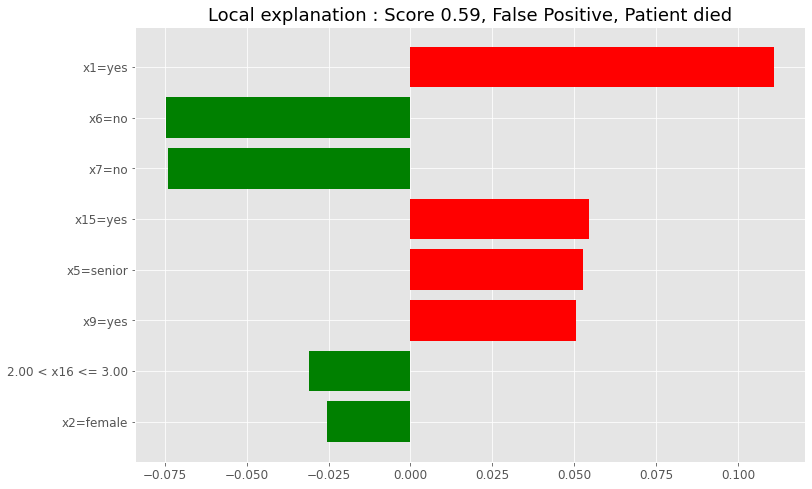

In [85]:
explaination = explainer.explain_instance(test_sample_incorrect.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 0
outcome_title = 'died'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

## Incorrect, person died, score 77%

In [135]:
test_sample_incorrect = get_test_sample(ensemble_pipeline, correct=False, survived=False, seed=58) #, correct=True, seed=42
test_sample_incorrect

,sex,age,chr_resp,chr_cvs,chr_liv,chr_ren,immundis,immunrx,hepfail,lymphoma,metast,leukaem,immunsup,cirrhos,iddm,arf,gcsverb,gcsmotor,gcseye,urineop,temphi,templo,hrhi,hrlo,rrhi,rrlo,systolichi,systoliclo,diastolichi,diastoliclo,maphi,maplo,nahi,nalo,khi,klo,hco3hi,hco3lo,creathi,creatlo,hcthi,hctlo,hmgnhi,hmgnlo,wcchi,wcclo,plathi,platlo,gluchi,gluclo,pre_icu_hrs,intubated,ventilated,elect
2809,1,69.199997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,1.0,1.0,1.0,3370.0,35.900002,35.200001,65.0,50.0,16.0,12.0,130.0,85.0,70.0,50.0,90.0,62.0,134.0,130.0,4.1,3.8,28.0,24.0,77.0,75.0,0.4,0.35,13.3,11.4,10.5,7.8,170.0,111.0,12.0,7.2,0.0,1.0,1.0,0.0


In [136]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_incorrect)
score = round(result[0,0],2)
score

0.77

Intercept 0.4280182590422288
Prediction_local [0.50149541]
Right: 0.2337855997957723


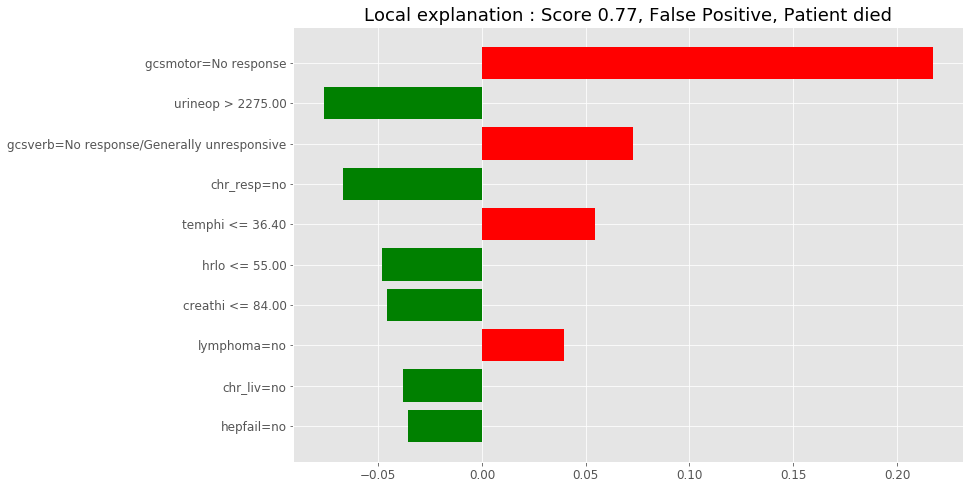

In [137]:
explaination = explainer.explain_instance(test_sample_incorrect.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 0
outcome_title = 'died'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

## Incorrect, person lived, score 29%

In [146]:
test_sample_incorrect = get_test_sample(ensemble_pipeline, correct=False, survived=True, seed=4) #, correct=True, seed=42
test_sample_incorrect

,sex,age,chr_resp,chr_cvs,chr_liv,chr_ren,immundis,immunrx,hepfail,lymphoma,metast,leukaem,immunsup,cirrhos,iddm,arf,gcsverb,gcsmotor,gcseye,urineop,temphi,templo,hrhi,hrlo,rrhi,rrlo,systolichi,systoliclo,diastolichi,diastoliclo,maphi,maplo,nahi,nalo,khi,klo,hco3hi,hco3lo,creathi,creatlo,hcthi,hctlo,hmgnhi,hmgnlo,wcchi,wcclo,plathi,platlo,gluchi,gluclo,pre_icu_hrs,intubated,ventilated,elect
1170,1,54.400002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,1.0,1.0,1.0,1.0,1440.0,38.400002,34.700001,100.0,65.0,18.0,16.0,192.0,98.0,102.0,56.0,132.0,70.0,142.0,137.0,6.1,4.0,26.0,21.0,233.0,196.0,0.34,0.34,11.4,11.1,11.9,11.2,211.0,201.0,11.3,8.7,2.6,1.0,1.0,0.0


In [147]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_incorrect)
score = round(result[0,0],2)
score

0.29

Intercept 0.2661094106381957
Prediction_local [0.72228309]
Right: 0.7144123206198975


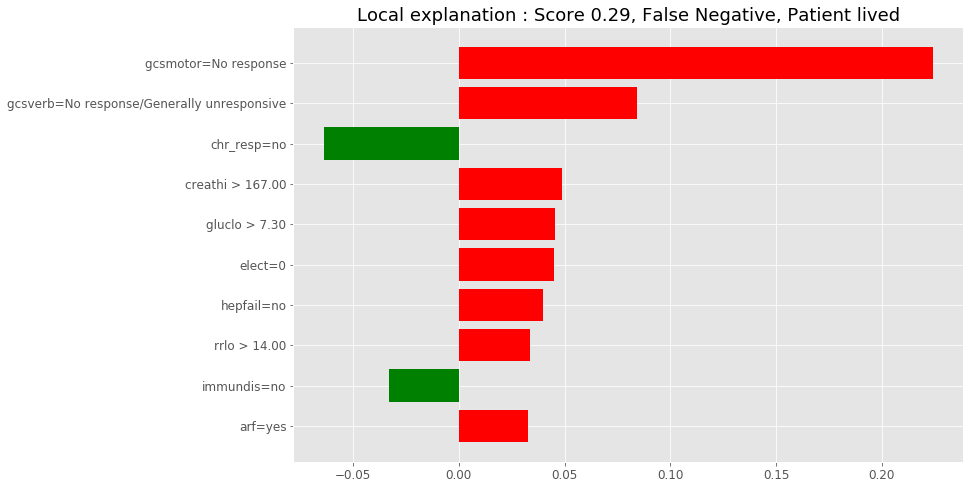

In [148]:
explaination = explainer.explain_instance(test_sample_incorrect.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 1
outcome_title = 'lived'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

## Incorrect, Person lived, Score 22%

In [149]:
test_sample_incorrect = get_test_sample(ensemble_pipeline, correct=False, survived=True, seed=48) #, correct=True, seed=42
test_sample_incorrect

,sex,age,chr_resp,chr_cvs,chr_liv,chr_ren,immundis,immunrx,hepfail,lymphoma,metast,leukaem,immunsup,cirrhos,iddm,arf,gcsverb,gcsmotor,gcseye,urineop,temphi,templo,hrhi,hrlo,rrhi,rrlo,systolichi,systoliclo,diastolichi,diastoliclo,maphi,maplo,nahi,nalo,khi,klo,hco3hi,hco3lo,creathi,creatlo,hcthi,hctlo,hmgnhi,hmgnlo,wcchi,wcclo,plathi,platlo,gluchi,gluclo,pre_icu_hrs,intubated,ventilated,elect
2719,1,28.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,1.0,1.0,1.0,1.0,520.0,37.900002,34.400002,130.0,90.0,18.0,15.0,140.0,90.0,90.0,40.0,107.0,57.0,141.0,139.0,5.4,4.4,21.0,18.0,320.0,140.0,0.46,0.34,16.1,11.2,20.700001,13.7,149.0,67.0,7.0,4.4,0.8,1.0,1.0,0.0


In [154]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_incorrect)
score = round(result[0,0],2)
score

0.22

Intercept 0.3328040620164847
Prediction_local [0.73623432]
Right: 0.7824032129022999


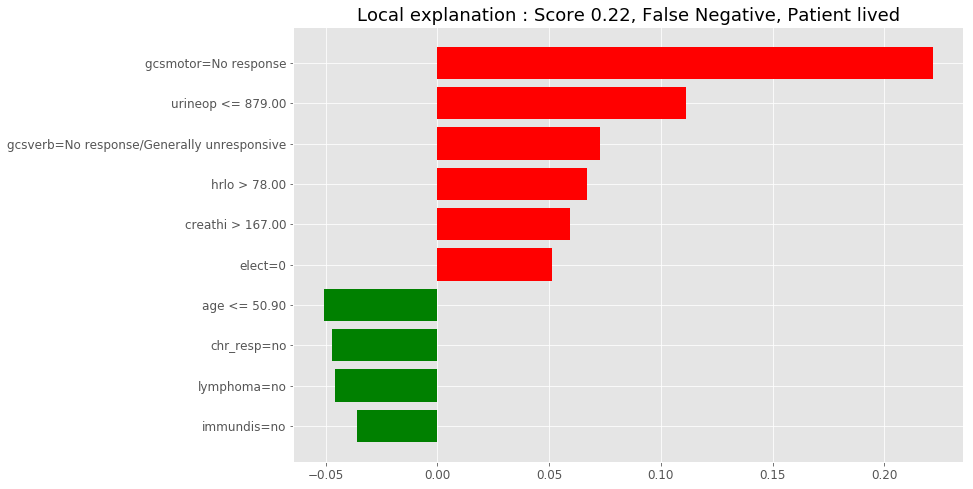

In [155]:
explaination = explainer.explain_instance(test_sample_incorrect.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 1
outcome_title = 'lived'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

## h2o deep learner

In [70]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,2 days 0 hours 36 mins
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,"7 days, 21 hours and 25 minutes"
H2O cluster name:,H2O_from_python_ubuntu_cwa5yz
H2O cluster total nodes:,1
H2O cluster free memory:,496.9 Mb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"locked, healthy"


In [71]:
deep_learner_model = h2o.load_model(path='../models/h2o_deep_learner_may31/DeepLearning_grid_0_AutoML_20180531_041722_model_20')
deep_learner_model

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_0_AutoML_20180531_041722_model_20


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.14800559030866028
RMSE: 0.38471494682252766
LogLoss: 0.4536492080270956
Mean Per-Class Error: 0.2127796914896426
AUC: 0.8682829469027927
Gini: 0.7365658938055855
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43762231271646723: 


,0,1,Error,Rate
0,3729.0,1313.0,0.2604,(1313.0/5042.0)
1,879.0,4109.0,0.1762,(879.0/4988.0)
Total,4608.0,5422.0,0.2185,(2192.0/10030.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4376223,0.7894332,218.0
max f2,0.1747394,0.8659439,323.0
max f0point5,0.5968780,0.8051050,157.0
max accuracy,0.4925697,0.7872383,198.0
max precision,0.9889057,0.9897260,6.0
max recall,0.0072004,1.0,395.0
max specificity,0.9993661,0.9998017,0.0
max absolute_mcc,0.5221579,0.5752987,186.0
max min_per_class_accuracy,0.4849778,0.7863943,201.0
max mean_per_class_accuracy,0.4898166,0.7872203,199.0


Gains/Lift Table: Avg response rate: 49.73 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100698,0.9975818,1.9710076,1.9710076,0.9801980,0.9801980,0.0198476,0.0198476,97.1007646,97.1007646
,2,0.0200399,0.9931860,1.9907177,1.9808137,0.99,0.9850746,0.0198476,0.0396953,99.0717723,98.0813654
,3,0.0300100,0.9869960,1.9907177,1.9841040,0.99,0.9867110,0.0198476,0.0595429,99.0717723,98.4104042
,4,0.0400798,0.9799954,1.9510985,1.9758116,0.9702970,0.9825871,0.0196472,0.0791901,95.1098478,97.5811600
,5,0.0500499,0.9727082,1.9505012,1.9707697,0.97,0.9800797,0.0194467,0.0986367,95.0501203,97.0769688
,6,0.1,0.9321467,1.9305535,1.9506816,0.9600798,0.9700897,0.0964314,0.1950682,93.0553488,95.0681636
,7,0.1500499,0.8780543,1.8826458,1.9279880,0.9362550,0.9588040,0.0942261,0.2892943,88.2645840,92.7987968
,8,0.2,0.8218892,1.7539540,1.8845229,0.8722555,0.9371884,0.0876103,0.3769046,75.3954001,88.4522855
,9,0.3,0.7118376,1.6319166,1.8003208,0.8115653,0.8953141,0.1631917,0.5400962,63.1916600,80.0320770
,10,0.4,0.5932352,1.3853248,1.6965718,0.6889332,0.8437188,0.1385325,0.6786287,38.5324779,69.6571772




ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.16074496691797896
RMSE: 0.4009301272266515
LogLoss: 0.4900698083031297
Mean Per-Class Error: 0.23925469457703452
AUC: 0.8449362320593411
Gini: 0.6898724641186822
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34726684097703825: 


,0,1,Error,Rate
0,1183.0,796.0,0.4022,(796.0/1979.0)
1,222.0,1750.0,0.1126,(222.0/1972.0)
Total,1405.0,2546.0,0.2577,(1018.0/3951.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3472668,0.7746791,257.0
max f2,0.1774398,0.8639622,323.0
max f0point5,0.6210830,0.7727160,153.0
max accuracy,0.5462599,0.7608200,180.0
max precision,0.9830917,0.9859155,9.0
max recall,0.0012723,1.0,399.0
max specificity,0.9992940,0.9994947,0.0
max absolute_mcc,0.5462599,0.5238131,180.0
max min_per_class_accuracy,0.4988018,0.7574533,200.0
max mean_per_class_accuracy,0.5426410,0.7607453,182.0


Gains/Lift Table: Avg response rate: 49.91 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0101240,0.9967329,1.9534610,1.9534610,0.975,0.975,0.0197769,0.0197769,95.3460953,95.3460953
,2,0.0202480,0.9918798,1.9534610,1.9534610,0.975,0.975,0.0197769,0.0395538,95.3460953,95.3460953
,3,0.0301190,0.9853465,2.0035497,1.9698766,1.0,0.9831933,0.0197769,0.0593306,100.3549696,96.9876592
,4,0.0402430,0.9786605,1.9534610,1.9657469,0.975,0.9811321,0.0197769,0.0791075,95.3460953,96.5746871
,5,0.0501139,0.9716897,1.9521766,1.9630739,0.9743590,0.9797980,0.0192698,0.0983773,95.2176627,96.3073944
,6,0.1002278,0.9316733,1.8517656,1.9074198,0.9242424,0.9520202,0.0927992,0.1911765,85.1765628,90.7419786
,7,0.1500886,0.8797176,1.7086109,1.8413737,0.8527919,0.9190556,0.0851927,0.2763692,70.8610908,84.1373666
,8,0.2002025,0.8219483,1.8011709,1.8313103,0.8989899,0.9140329,0.0902637,0.3666329,80.1170939,83.1310278
,9,0.3001772,0.7131273,1.5318279,1.7315670,0.7645570,0.8642496,0.1531440,0.5197769,53.1827869,73.1566980
,10,0.4001519,0.6039069,1.2782140,1.6183004,0.6379747,0.8077166,0.1277890,0.6475659,27.8213983,61.8300418




ModelMetricsBinomial: deeplearning
** Reported on cross-validation data. **

MSE: 0.16505155554641368
RMSE: 0.40626537576615324
LogLoss: 0.5042214101247114
Mean Per-Class Error: 0.2422989297286633
AUC: 0.8367137076885889
Gini: 0.6734274153771778
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40531565877000764: 


,0,1,Error,Rate
0,5450.0,2694.0,0.3308,(2694.0/8144.0)
1,1327.0,6500.0,0.1695,(1327.0/7827.0)
Total,6777.0,9194.0,0.2518,(4021.0/15971.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4053157,0.7637624,232.0
max f2,0.1434611,0.8538724,336.0
max f0point5,0.6165054,0.7649167,150.0
max accuracy,0.4736563,0.7573727,205.0
max precision,0.9965141,0.9656863,2.0
max recall,0.0035131,1.0,398.0
max specificity,0.9990339,0.9995088,0.0
max absolute_mcc,0.4736563,0.5154352,205.0
max min_per_class_accuracy,0.4913235,0.7555255,199.0
max mean_per_class_accuracy,0.4736563,0.7577011,205.0


Gains/Lift Table: Avg response rate: 49.01 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100182,0.9967069,1.9639820,1.9639820,0.9625,0.9625,0.0196755,0.0196755,96.3982049,96.3982049
,2,0.0200363,0.9909115,1.9384758,1.9512289,0.95,0.95625,0.0194200,0.0390954,93.8475789,95.1228919
,3,0.0300545,0.9838260,1.9767352,1.9597310,0.96875,0.9604167,0.0198032,0.0588987,97.6735180,95.9731006
,4,0.0400100,0.9753979,1.8993341,1.9447027,0.9308176,0.9530516,0.0189089,0.0778076,89.9334106,94.4702669
,5,0.0500282,0.9670048,1.9002164,1.9357943,0.93125,0.9486859,0.0190367,0.0968443,90.0216398,93.5794280
,6,0.1000564,0.9233021,1.8949332,1.9153637,0.9286608,0.9386733,0.0948001,0.1916443,89.4933187,91.5363733
,7,0.1500219,0.8716229,1.8001411,1.8769882,0.8822055,0.9198664,0.0899451,0.2815894,80.0141084,87.6988243
,8,0.2000501,0.8158913,1.7110583,1.8354928,0.8385482,0.8995305,0.0856011,0.3671905,71.1058268,83.5492766
,9,0.3000438,0.7011130,1.5179180,1.7296566,0.7438948,0.8476628,0.1517823,0.5189728,51.7917963,72.9656589
,10,0.4000376,0.5918612,1.3211508,1.6275461,0.6474640,0.7976209,0.1321068,0.6510796,32.1150819,62.7546131



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.750047,0.0053970,0.7489828,0.7564183,0.7404509,0.7608015,0.7435817
auc,0.8367764,0.0036440,0.8403649,0.8350789,0.8347657,0.8443523,0.8293202
err,0.2499530,0.0053970,0.2510172,0.2435817,0.2595491,0.2391985,0.2564183
err_count,798.4,17.24297,802.0,778.0,829.0,764.0,819.0
f0point5,0.7295371,0.0076171,0.7305582,0.7441132,0.7171672,0.7381331,0.717714
f1,0.766559,0.0061497,0.7786975,0.7673445,0.7553850,0.7728894,0.7584783
f2,0.807768,0.0101805,0.8336287,0.7920731,0.7979055,0.8110806,0.8041521
lift_top_group,1.9383657,0.0538910,1.9188818,2.015142,2.0040073,1.8030645,1.950733
logloss,0.5042213,0.0047492,0.5064428,0.5020511,0.4991452,0.4973126,0.5161547
max_per_class_error,0.3347519,0.0203008,0.3792667,0.2958359,0.3424242,0.3126521,0.3435805


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2018-05-31 05:48:33,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2018-05-31 05:48:34,1:31:01.810,57856 obs/sec,4.9810281,1,79552.0,0.4129100,0.5177287,0.8276685,1.9909168,0.2517448,0.4159994,0.5336899,0.8226652,1.9534610,0.2624652
,2018-05-31 05:48:40,1:31:07.778,65922 obs/sec,29.8839146,6,477276.0,0.3965237,0.4779505,0.8515330,1.9510985,0.2380857,0.4019624,0.4969399,0.8432057,1.9033722,0.2548722
,2018-05-31 05:48:45,1:31:13.171,69812 obs/sec,54.7846722,11,874966.0,0.3932246,0.4713822,0.8563671,1.9510985,0.2323031,0.4014096,0.4962327,0.8441227,1.9033722,0.2604404
,2018-05-31 05:48:51,1:31:18.363,72252 obs/sec,79.6855551,16,1272658.0,0.3910607,0.4668044,0.8595070,1.9510985,0.2281157,0.4008057,0.4942688,0.8449994,1.9033722,0.2525943
,2018-05-31 05:48:56,1:31:23.393,74125 obs/sec,104.5866884,21,1670354.0,0.3898191,0.4645653,0.8614433,1.9510985,0.2248255,0.4012675,0.4948088,0.8443058,1.9534610,0.2568970
,2018-05-31 05:49:01,1:31:29.246,75947 obs/sec,134.4717300,27,2147648.0,0.3880575,0.4607201,0.8638289,1.9510985,0.2205384,0.4007597,0.4927313,0.8451101,1.9033722,0.2553784
,2018-05-31 05:49:07,1:31:34.945,77483 obs/sec,164.3495085,33,2624826.0,0.3863509,0.4569962,0.8661024,1.9710076,0.2199402,0.4009105,0.4916847,0.8448642,1.9534610,0.2531005
,2018-05-31 05:49:13,1:31:40.525,78823 obs/sec,194.2289149,39,3102030.0,0.3850845,0.4542639,0.8676663,1.9710076,0.2192423,0.4010173,0.4912514,0.8448316,1.9534610,0.2576563
,2018-05-31 05:49:15,1:31:42.449,79197 obs/sec,204.1890301,41,3261103.0,0.3847149,0.4536492,0.8682829,1.9710076,0.2185444,0.4009301,0.4900698,0.8449362,1.9534610,0.2576563


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
pre_icu_hrs,1.0,1.0,0.0753679
creathi,0.5207726,0.5207726,0.0392495
gcsmotor,0.4261130,0.4261130,0.0321152
rrhi,0.3963816,0.3963816,0.0298744
urineop,0.3544414,0.3544414,0.0267135
---,---,---,---
cirrhos,0.1239960,0.1239960,0.0093453
immunrx,0.1211822,0.1211822,0.0091332
immundis,0.1173369,0.1173369,0.0088434
iddm,0.1122052,0.1122052,0.0084567



See the whole table with table.as_data_frame()


In [72]:
deep_learner_model.summary()

Status of Neuron Layers: predicting died_hosp, 2-class classification, bernoulli distribution, CrossEntropy loss, 2,852 weights/biases, 45.2 KB, 3,261,103 training samples, mini-batch size 1



,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
,1,54,Input,5.0,,,,,,,,,
,2,50,RectifierDropout,30.0,0.0,0.0,0.0025496,0.0047209,0.0,0.0059734,0.2746736,-0.4880718,0.3510858
,3,2,Softmax,,0.0,0.0,0.0002649,0.0001681,0.0,-0.0899859,0.4985533,-0.0039189,0.0563488


In [73]:
class DeepLearner_clf(BaseEstimator, ClassifierMixin):
    def fit(self, X, y=None):
        return deep_learner_model
    def predict_proba(self, X):
        pdX = pd.DataFrame(X, columns=categorical_vars + numerical_vars)
        hX = h2o.H2OFrame(pdX)
        result = deep_learner_model.predict(hX)    
        return result.as_data_frame().as_matrix(['p0', 'p1'])

In [74]:
## for ensemble_clf
deeplearning_pipeline = Pipeline([
    ('preprocessing', FeatureUnion(transformer_list=[
                            ('cat_pipeline', cat_vars_pipeline),
                            ('num_pipeline', num_vars_pipeline),
                        ])),
    ('deeplearning_clf', DeepLearner_clf())
])

In [75]:
deeplearning_pipeline.fit(train)

Pipeline(memory=None,
     steps=[('preprocessing', FeatureUnion(n_jobs=1,
       transformer_list=[('cat_pipeline', Pipeline(memory=None,
     steps=[('selector', Vars_selector(var_idxs=[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 51, 52, 53])), ('encoder', Cat_vars_encoder())])), ('num_pipeline', Pipeline...ue, with_std=True))]))],
       transformer_weights=None)), ('deeplearning_clf', DeepLearner_clf())])

Let's grab four sets of patients and results (True Positive, False Positive, True Negative, False Negative)

In [76]:
sample_correct_survived = get_test_sample(deeplearning_pipeline, correct=True, survived=True, seed=48, count=10)
result_correct_survived = deeplearning_pipeline.predict_proba(sample_correct_survived)
result_correct_survived

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


array([[0.63014533, 0.36985467],
       [0.86886768, 0.13113232],
       [0.51395096, 0.48604904],
       [0.89553304, 0.10446696],
       [0.98218127, 0.01781873],
       [0.91445695, 0.08554305],
       [0.61197099, 0.38802901],
       [0.92566822, 0.07433178],
       [0.82138594, 0.17861406],
       [0.97032382, 0.02967618]])

In [77]:
sample_correct_died = get_test_sample(deeplearning_pipeline, correct=True, survived=False, seed=48, count=20)
result_correct_died = deeplearning_pipeline.predict_proba(sample_correct_died)
result_correct_died

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


array([[1.98004238e-01, 8.01995762e-01],
       [1.01568096e-02, 9.89843190e-01],
       [7.01911599e-02, 9.29808840e-01],
       [9.87523781e-03, 9.90124762e-01],
       [2.53782605e-01, 7.46217395e-01],
       [4.19078495e-02, 9.58092150e-01],
       [6.16133154e-04, 9.99383867e-01],
       [1.58705771e-01, 8.41294229e-01],
       [6.16183687e-02, 9.38381631e-01],
       [3.08473645e-01, 6.91526355e-01],
       [2.88981735e-02, 9.71101827e-01],
       [2.84135230e-01, 7.15864770e-01],
       [3.94851500e-01, 6.05148500e-01],
       [2.91733130e-01, 7.08266870e-01],
       [2.81256591e-02, 9.71874341e-01],
       [8.58935454e-02, 9.14106455e-01],
       [3.91790410e-01, 6.08209590e-01],
       [4.60334693e-01, 5.39665307e-01],
       [1.62428925e-01, 8.37571075e-01],
       [1.53055763e-01, 8.46944237e-01]])

In [78]:
sample_incorrect_survived = get_test_sample(deeplearning_pipeline, correct=False, survived=True, seed=48, count=10)
result_incorrect_survived = deeplearning_pipeline.predict_proba(sample_incorrect_survived)
result_incorrect_survived

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


array([[0.42420715, 0.57579285],
       [0.0634237 , 0.9365763 ],
       [0.35293518, 0.64706482],
       [0.48023221, 0.51976779],
       [0.46195379, 0.53804621],
       [0.39588404, 0.60411596],
       [0.14248451, 0.85751549],
       [0.44678014, 0.55321986],
       [0.46967586, 0.53032414],
       [0.27684296, 0.72315704]])

In [96]:
sample_incorrect_died = get_test_sample(deeplearning_pipeline, correct=False, survived=False, seed=48, count=10)
result_incorrect_died = deeplearning_pipeline.predict_proba(sample_incorrect_died)
result_incorrect_died

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


array([[0.94034141, 0.05965859],
       [0.80112147, 0.19887853],
       [0.8464552 , 0.1535448 ],
       [0.54589856, 0.45410144],
       [0.53209638, 0.46790362],
       [0.79637541, 0.20362459],
       [0.58687308, 0.41312692],
       [0.59967133, 0.40032867],
       [0.79427688, 0.20572312],
       [0.71010547, 0.28989453]])

## Results Correct, Died, 4%

In [97]:
index = 5
sample = pd.DataFrame(sample_correct_died.iloc[index])
score = round(result_correct_died[index][0],2)
score

0.04

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
Intercept 0.5417526362274396
Prediction_local [0.87343074]
Right: 0.9580921504519726


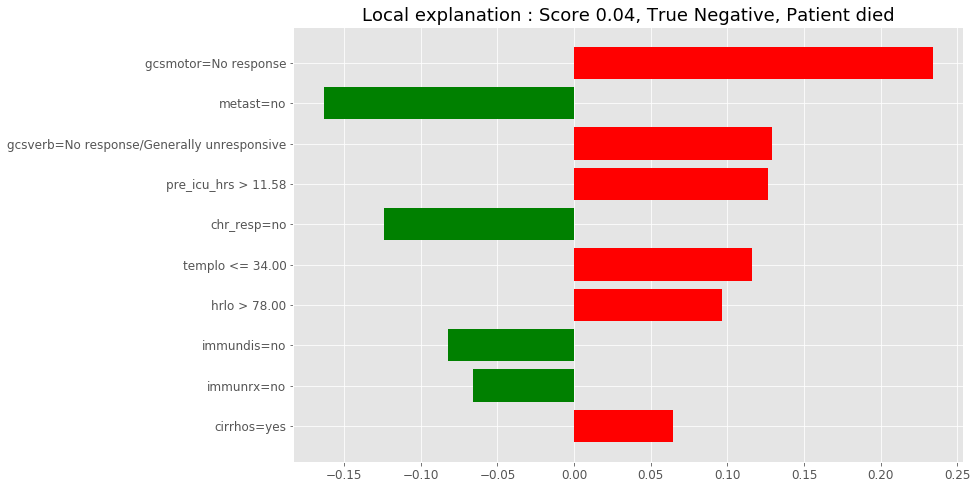

In [98]:
explaination = explainer.explain_instance(sample.values.ravel(), deeplearning_pipeline.predict_proba, 
                                          num_features = 10, num_samples = 5000)
print(explaination)
outcome = 0
outcome_title = 'died'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

## Results Correct, Died, 16%

In [99]:
index = 7
sample = pd.DataFrame(sample_correct_died.iloc[index])
score = round(result_correct_died[index][0],2)
score

0.16

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
Intercept 0.5928588608981709
Prediction_local [0.67432864]
Right: 0.8412942285578521


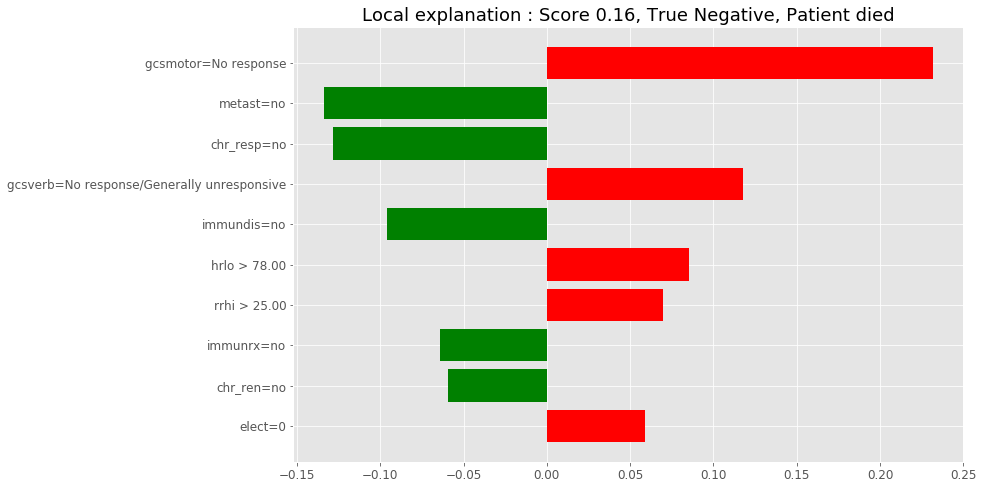

In [100]:
explaination = explainer.explain_instance(sample.values.ravel(), deeplearning_pipeline.predict_proba, 
                                          num_features = 10, num_samples = 5000)
print(explaination)
outcome = 0
outcome_title = 'died'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

## Results Correct, Lived, 63%

In [101]:
index = 0
sample = pd.DataFrame(sample_correct_survived.iloc[index])
score = round(result_correct_survived[index][0],2)
score

0.63

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
Intercept 0.8814321650903438
Prediction_local [0.32029024]
Right: 0.3698546699474373


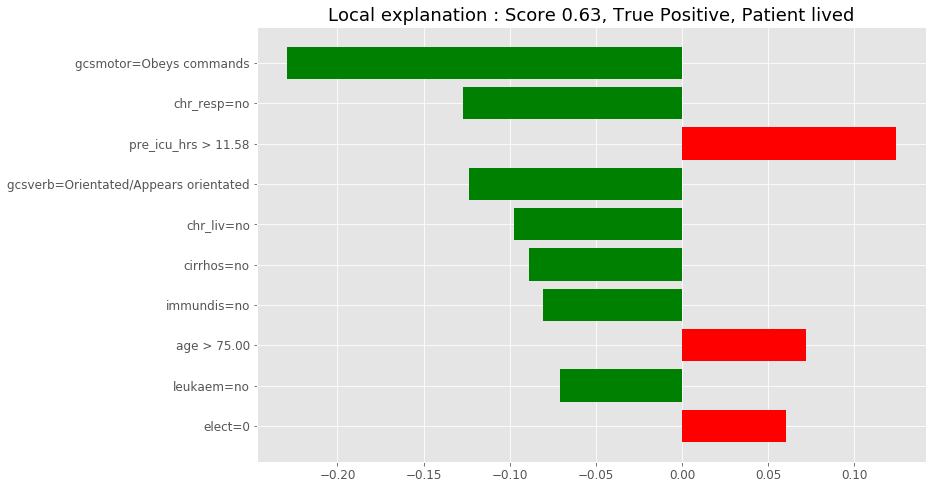

In [102]:
explaination = explainer.explain_instance(sample.values.ravel(), deeplearning_pipeline.predict_proba, 
                                          num_features = 10, num_samples = 5000)
print(explaination)
outcome = 1
outcome_title = 'lived'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

## Results Correct, Lived, 90%

In [103]:
index = 3
sample = pd.DataFrame(sample_correct_survived.iloc[index])
score = round(result_correct_survived[index][0],2)
score

0.9

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
Intercept 0.9078070315080888
Prediction_local [0.34039883]
Right: 0.10446696051792824


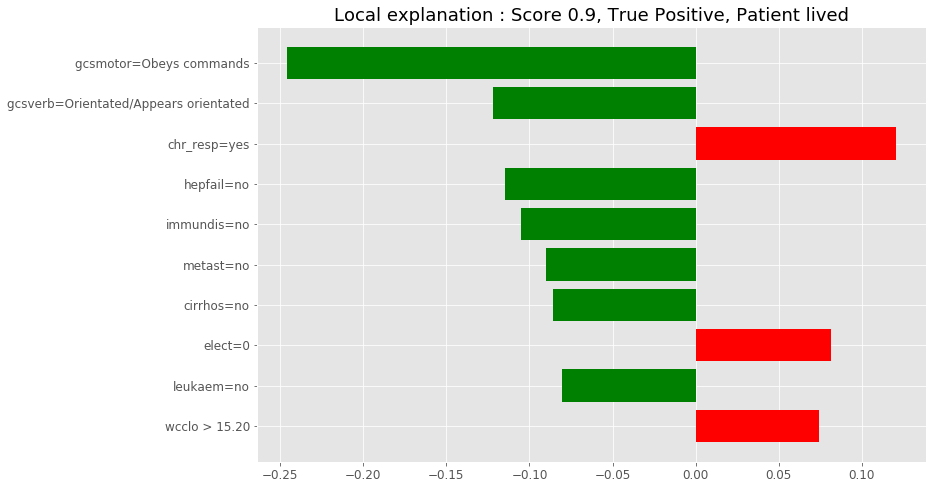

In [104]:
explaination = explainer.explain_instance(sample.values.ravel(), deeplearning_pipeline.predict_proba, 
                                          num_features = 10, num_samples = 5000)
print(explaination)
outcome = 1
outcome_title = 'lived'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

## Results Incorrect, Died, 80%

In [105]:
index = 1
sample = pd.DataFrame(sample_incorrect_died.iloc[index])
score = round(result_incorrect_died[index][0],2)
score

0.8

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
Intercept 0.820738756023302
Prediction_local [0.52045212]
Right: 0.1988785258744663


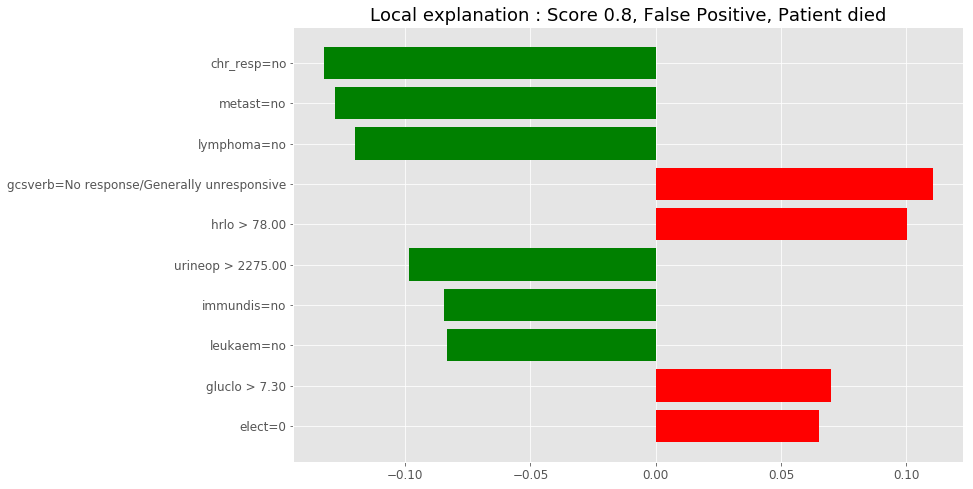

In [106]:
explaination = explainer.explain_instance(sample.values.ravel(), deeplearning_pipeline.predict_proba, 
                                          num_features = 10, num_samples = 5000)
print(explaination)
outcome = 0
outcome_title = 'died'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

## Results Incorrect, Died, 53%

In [107]:
index = 4
sample = pd.DataFrame(sample_incorrect_died.iloc[index])
score = round(result_incorrect_died[index][0],2)
score

0.53

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
Intercept 0.6885662084075719
Prediction_local [0.6624993]
Right: 0.4679036248151045


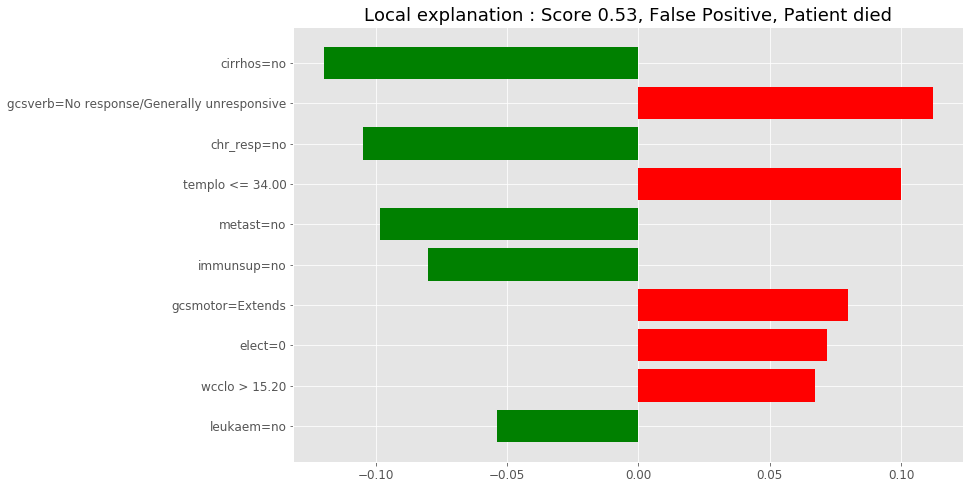

In [108]:
explaination = explainer.explain_instance(sample.values.ravel(), deeplearning_pipeline.predict_proba, 
                                          num_features = 10, num_samples = 5000)
print(explaination)

outcome = 0
outcome_title = 'died'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

## Results Incorrect, lived, 42%

In [109]:
index = 0
sample = pd.DataFrame(sample_incorrect_survived.iloc[index])
result_incorrect_survived[index]

array([0.42420715, 0.57579285])

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
Intercept 0.5591833141510114
Prediction_local [0.60763606]
Right: 0.5757928510536824


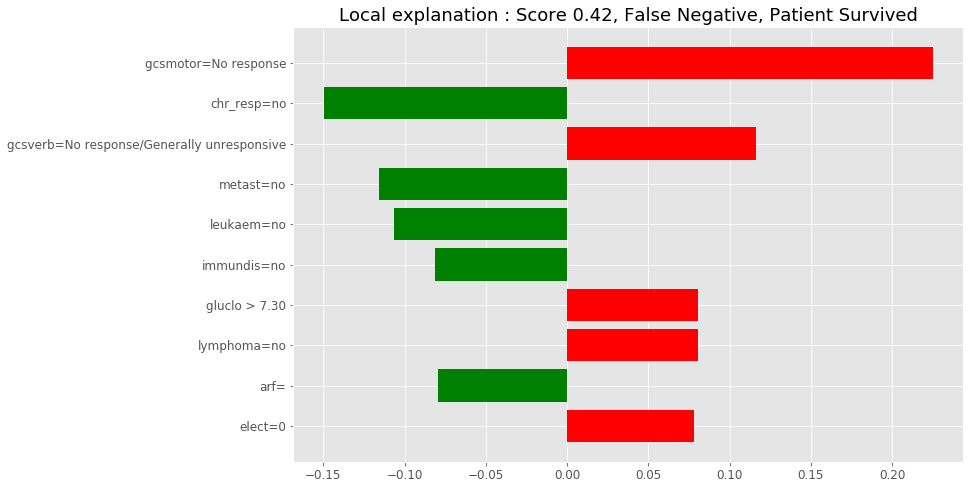

In [110]:
explaination = explainer.explain_instance(sample.values.ravel(), deeplearning_pipeline.predict_proba, 
                                          num_features = 10, num_samples = 5000)
print(explaination)
score = round(result_incorrect_survived[index][0],2)
outcome = 1
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient Survived'.format(score, score_compare(score, outcome)))

## Results Incorrect, lived, 6%

In [111]:
index = 1
sample = pd.DataFrame(sample_incorrect_survived.iloc[index])
result_incorrect_survived[index]

array([0.0634237, 0.9365763])

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
Intercept 0.8624917327301747
Prediction_local [0.35833746]
Right: 0.9365763040221916


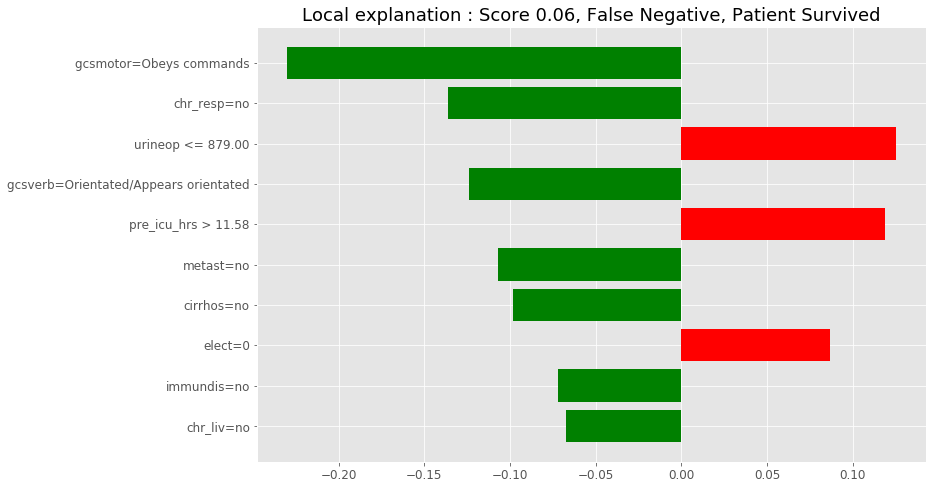

In [112]:
explaination = explainer.explain_instance(sample.values.ravel(), deeplearning_pipeline.predict_proba, 
                                          num_features = 10, num_samples = 5000)
print(explaination)
score = round(result_incorrect_survived[index][0],2)
outcome = 1
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient Survived'.format(score, score_compare(score, outcome)))